Starting hyperparameter optimisation...
[iter 0] avg CV loss: 0.053259
lengthscale: tensor([0.3495, 0.3495, 0.2861, 0.2861, 0.2861, 0.2861, 0.2861, 0.2861, 0.2861,
        0.2861], grad_fn=<ExpBackward0>)
[iter 10] avg CV loss: 0.044233
lengthscale: tensor([0.8920, 0.9106, 0.5474, 0.3410, 0.2664, 0.2278, 0.1682, 0.1512, 0.1282,
        0.1319], grad_fn=<ExpBackward0>)
[iter 20] avg CV loss: 0.043841
lengthscale: tensor([1.5202, 1.6081, 0.3713, 0.2831, 0.3033, 0.2605, 0.2378, 0.2037, 0.1088,
        0.1313], grad_fn=<ExpBackward0>)
[iter 30] avg CV loss: 0.043562
lengthscale: tensor([2.0142, 2.0193, 0.4864, 0.2790, 0.2664, 0.2290, 0.2032, 0.1914, 0.1248,
        0.1614], grad_fn=<ExpBackward0>)
[iter 40] avg CV loss: 0.043558
lengthscale: tensor([2.3428, 2.1983, 0.3973, 0.2864, 0.2702, 0.2426, 0.1945, 0.1789, 0.1394,
        0.1596], grad_fn=<ExpBackward0>)
[iter 50] avg CV loss: 0.043520
lengthscale: tensor([2.5484, 2.2475, 0.4468, 0.2791, 0.2770, 0.2348, 0.2127, 0.1940, 0.1318,
      

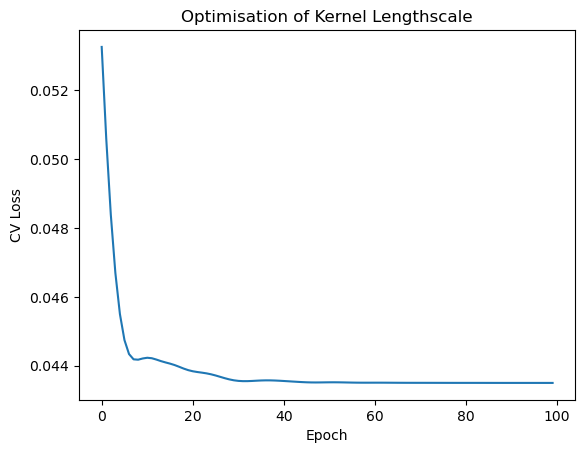

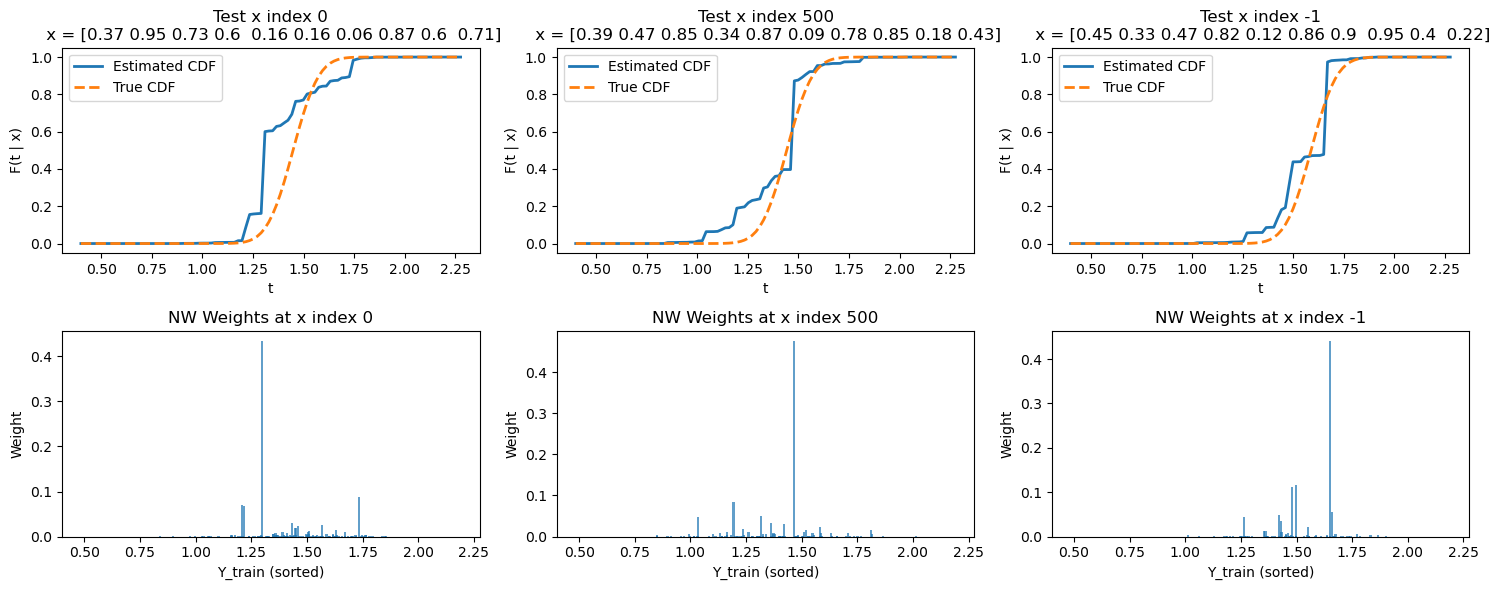

In [48]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Use your synthetic data generator (or define one here)
def generate_data(n_samples, d, sigma=0.1, random_state=42):
    np.random.seed(random_state)
    # Generate d-dimensional features uniformly on [0,1]
    X = np.random.uniform(0, 1, size=(n_samples, d))
    # Define beta = [1, 2, ..., d] normalized
    beta = np.arange(1, d + 1, dtype=float)
    beta /= np.linalg.norm(beta)
    # Linear model: y = beta^T X + noise
    y = X.dot(beta) + np.random.normal(0, sigma, size=n_samples)
    return X, y, beta

# Toggle dimensionality and sample sizes
d = 10           # Try with d = 1,3,5,10, etc.
n_train = 1000
n_test = 1000
sigma = 0.1

X_train_np, Y_train_np, beta = generate_data(n_train, d, sigma=sigma)
X_test_np, Y_test_np, _ = generate_data(n_test, d, sigma=sigma)

# Convert to torch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32).unsqueeze(1)  # shape (N, 1)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
Y_test = torch.tensor(Y_test_np, dtype=torch.float32).unsqueeze(1)

# -----------------------------------------------------------------------------
# 1. Instantiate a GaussianKernel and NWFunctional from your modules
# -----------------------------------------------------------------------------
from causal_cocycle.kernels_new import GaussianKernel  # :contentReference[oaicite:3]{index=3}
from causal_cocycle.regression_functionals import NWFunctional  # :contentReference[oaicite:4]{index=4}

# Create a GaussianKernel with an initial lengthscale (here set to 0.2)
kernel = GaussianKernel(lengthscale=torch.ones(d)/ d**0.5)

# Create the NWFunctional with this kernel (reg=0.0 in this example)
functional = NWFunctional(kernel=kernel, reg=0.0)

# -----------------------------------------------------------------------------
# 2. Wrap the NWFunctional in your ConditionalExpectationRegressor
# -----------------------------------------------------------------------------
from causal_cocycle.distribution_estimation import ConditionalExpectationRegressor  # :contentReference[oaicite:5]{index=5}

CER = ConditionalExpectationRegressor(functional)

# -----------------------------------------------------------------------------
# 3. Optimize the kernel hyperparameters (i.e. the lengthscale) using your optimise module
# -----------------------------------------------------------------------------
# Here we optimize the NWFunctional’s kernel lengthscale via CV loss.
# The optimiser will use your NWFunctional’s hyperparameter list, which in this case is [kernel.log_lengthscale].
print("Starting hyperparameter optimisation...")
test_points = torch.linspace(Y_train.min()-0.1, Y_train.max()+0.1, 100)[:,None]
feature = (Y_train <= test_points.T).float()
losses = CER.optimise(X_train, feature, maxiter=100, nfold=5, learn_rate=1e-1, print_=True)

# Plot the training CV loss curve
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("CV Loss")
plt.title("Optimisation of Kernel Lengthscale")
plt.show()

from scipy.stats import norm

# ----------------------------------------------
# Evaluation: Compare estimated CDF vs true CDF
# ----------------------------------------------
test_indices = [0, n_test // 2, -1]
test_points_flat = test_points.squeeze().numpy()

fig, axs = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows: CDF + weights

for i, idx in enumerate(test_indices):
    x_query = X_test[idx][None]  # shape (1, d)
    x_np = X_test_np[idx]

    with torch.no_grad():
        cdf_pred = CER.functional(feature, X_train, x_query).detach().squeeze().numpy()

    # Compute true CDF under generative model
    true_mean = np.dot(x_np, beta)
    true_cdf = norm.cdf(test_points_flat, loc=true_mean, scale=sigma)

    # -- Top row: CDF plot --
    axs[0, i].plot(test_points_flat, cdf_pred, label='Estimated CDF', lw=2)
    axs[0, i].plot(test_points_flat, true_cdf, '--', label='True CDF', lw=2)
    axs[0, i].set_xlabel('t')
    axs[0, i].set_ylabel('F(t | x)')
    axs[0, i].set_title(f'Test x index {idx}\n x = {np.array_str(x_np, precision=2)}')
    axs[0, i].legend()

    # -- Bottom row: weight plot --
    K_row = CER.functional.kernel.get_gram(x_query, X_train).squeeze()  # (n_train,)
    weights = (K_row / K_row.sum()).detach().cpu().numpy()

    sort_idx = torch.argsort(Y_train.squeeze())
    weights_sorted = weights[sort_idx]
    Y_sorted = Y_train.squeeze()[sort_idx].numpy()

    axs[1, i].bar(Y_sorted, weights_sorted, alpha=0.7, width=0.01)
    axs[1, i].set_xlabel('Y_train (sorted)')
    axs[1, i].set_ylabel('Weight')
    axs[1, i].set_title(f'NW Weights at x index {idx}')
    axs[1, i].set_xlim(Y_sorted.min() - 0.1, Y_sorted.max() + 0.1)

plt.tight_layout()
plt.show()